#### Input
The input csv file is a concatenation of the `TEST-*_stats.csv` file output from `checker.py` (i.e., the last steps in `04_check_variants.sh`), which provides true positive, false positive, false negative, precision, and recall values after variant-calling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn


Bad key savefig.frameon in file /Users/yeemayseah/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/yeemayseah/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/yeemayseah/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

In [89]:
stats = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/cov_limit_10/20210615_all_stats_cov10tmp2.csv', header=None)

In [90]:
stats.rename(columns={0: 'file_prefix', 1: 'true_pos', 2: 'false_pos', 3: 'false_neg', 4: 'precision', 5: 'recall'}, inplace=True)

In [91]:
stats.loc[stats['recall'] == '.' , 'recall'] = np.nan
stats.loc[stats['precision'] == '.' , 'precision'] = np.nan
stats['recall'] = pd.to_numeric(stats['recall'])
stats['precision'] = pd.to_numeric(stats['precision'])

In [92]:
stats['true_pos'] = pd.to_numeric(stats['true_pos'])
stats['false_pos'] = pd.to_numeric(stats['false_pos'])
stats['false_neg'] = pd.to_numeric(stats['false_neg'])

In [93]:
num_snp = {'TEST-H37Rv20snps': 20, 'TEST-H37Rv200snps': 200, 'TEST-H37Rv2000snps': 2000, 'TEST-H37Rv20003snps': 20003, 'TEST-MTBREF': 0, 
            'TEST-MTBVAR1': 1048, 'TEST-MTBVAR2': 3277, 'TEST-MTBVAR3': 11, 'TEST-MTBVAR4': 149, 'TEST-MTBVAR5': 1480, 'TEST-MTBVAR6': 16468,
            'TEST-H37Rv10-3indels': 0, 'TEST-H37Rv10-4indels': 0, 'TEST-H37Rv10-5indels': 0, 'TEST-H37Rv10-6indels': 0,
             'TEST-H37Rv10-3medindels': 0, 'TEST-H37Rv10-4medindels': 0, 'TEST-H37Rv10-5medindels': 0, 'TEST-H37Rv10-6medindels': 0}
num_indel = {'TEST-H37Rv20snps': 0, 'TEST-H37Rv200snps': 0, 'TEST-H37Rv2000snps': 0, 'TEST-H37Rv20003snps': 0, 'TEST-MTBREF': 0, 
             'TEST-MTBVAR1': 3317, 'TEST-MTBVAR2': 1120, 'TEST-MTBVAR3': 9, 'TEST-MTBVAR4': 51, 'TEST-MTBVAR5': 524, 'TEST-MTBVAR6': 5472,
             'TEST-H37Rv10-3indels': 4294, 'TEST-H37Rv10-4indels': 439, 'TEST-H37Rv10-5indels': 44, 'TEST-H37Rv10-6indels': 4,
             'TEST-H37Rv10-3medindels': 4306, 'TEST-H37Rv10-4medindels': 439, 'TEST-H37Rv10-5medindels': 44, 'TEST-H37Rv10-6medindels': 4}

In [94]:
stats['dataset'] = [name.split('_')[0] for name in stats['file_prefix']]
stats['tool'] = [name.split('_')[-2] for name in stats['file_prefix']]
stats.loc[stats['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats.loc[stats['tool'] == 'normalized',:]['file_prefix']]
stats.loc[stats['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats.loc[stats['tool'] == 'normalized',:]['file_prefix']]
stats['num_snp'] = [int(num_snp[ds]) for ds in stats['dataset']]
stats['num_indel'] = [int(num_indel[ds]) for ds in stats['dataset']]
stats['total_mutations'] = stats['num_snp'] + stats['num_indel']
stats['low_cov_mutations_filtered'] = stats['total_mutations'] - stats['true_pos'] - stats['false_neg']

In [95]:
stats['filtered_total_mutations'] = stats['total_mutations'] - stats['low_cov_mutations_filtered']

In [96]:
stats['snp_density'] = stats['num_snp'] / 4411532

In [97]:
stats['indel_density'] = stats['num_indel'] / 4411532

In [98]:
stats['indel_snp_ratio'] = round(stats['num_indel']/stats['num_snp'], 2)

In [99]:
# remove duplicate tools
stats_noHC = stats[stats['tool'] != 'HaplotypeCaller']
stats_noduptools = stats_noHC[stats['tool'] != 'discosnp-edit']

In [100]:
stats_noduptools

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3indels_discosnp-edit_normalized_...,1894,1552,761,0.549623,0.713371,TEST-H37Rv10-3indels,discosnp,0,4294,4294,1639,2655,0.000000,0.000973,inf
1,TEST-H37Rv10-3indels_mq10_bcftools_normalized,2654,2613,1,0.503892,0.999623,TEST-H37Rv10-3indels,bcftools,0,4294,4294,1639,2655,0.000000,0.000973,inf
2,TEST-H37Rv10-3indels_mq10_deepvariant_normaliz...,2653,1606,2,0.622916,0.999247,TEST-H37Rv10-3indels,deepvariant,0,4294,4294,1639,2655,0.000000,0.000973,inf
3,TEST-H37Rv10-3indels_mq10_delly_normalized,0,0,2655,NaN,0.000000,TEST-H37Rv10-3indels,delly,0,4294,4294,1639,2655,0.000000,0.000973,inf
4,TEST-H37Rv10-3indels_mq10_freebayes_normalized,2603,1649,52,0.612183,0.980414,TEST-H37Rv10-3indels,freebayes,0,4294,4294,1639,2655,0.000000,0.000973,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,TEST-MTBVAR6_mq10_delly_normalized,0,3,19725,0.000000,0.000000,TEST-MTBVAR6,delly,16468,5472,21940,2215,19725,0.003733,0.001240,0.33
150,TEST-MTBVAR6_mq10_freebayes_normalized,19492,2205,233,0.898373,0.988188,TEST-MTBVAR6,freebayes,16468,5472,21940,2215,19725,0.003733,0.001240,0.33
151,TEST-MTBVAR6_mq10_gatk_normalized,19717,1994,8,0.908157,0.999594,TEST-MTBVAR6,gatk,16468,5472,21940,2215,19725,0.003733,0.001240,0.33
152,TEST-MTBVAR6_mq10_lancet_normalized,19448,1955,277,0.908658,0.985957,TEST-MTBVAR6,lancet,16468,5472,21940,2215,19725,0.003733,0.001240,0.33


In [101]:
stats_SNPonly = stats_noduptools[stats_noduptools['num_indel'] == 0]

In [102]:
stats_indelonly = stats_noduptools[stats_noduptools['num_snp'] == 0]

In [103]:
stats_SNPonly

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
56,TEST-H37Rv20003snps_discosnp-edit_normalized_P...,19354,12,432,0.999380,0.978166,TEST-H37Rv20003snps,discosnp,20003,0,20003,217,19786,0.004534,0.0,0.0
57,TEST-H37Rv20003snps_mq10_bcftools_normalized,19786,23,0,0.998839,1.000000,TEST-H37Rv20003snps,bcftools,20003,0,20003,217,19786,0.004534,0.0,0.0
58,TEST-H37Rv20003snps_mq10_deepvariant_normalize...,19786,21,0,0.998940,1.000000,TEST-H37Rv20003snps,deepvariant,20003,0,20003,217,19786,0.004534,0.0,0.0
59,TEST-H37Rv20003snps_mq10_deepvariant_normalized,19758,54,0,0.997274,1.000000,TEST-H37Rv20003snps,deepvariant,20003,0,20003,245,19758,0.004534,0.0,0.0
60,TEST-H37Rv20003snps_mq10_delly_normalized,0,0,19786,NaN,0.000000,TEST-H37Rv20003snps,delly,20003,0,20003,217,19786,0.004534,0.0,0.0
61,TEST-H37Rv20003snps_mq10_freebayes_normalized,19786,23,0,0.998839,1.000000,TEST-H37Rv20003snps,freebayes,20003,0,20003,217,19786,0.004534,0.0,0.0
62,TEST-H37Rv20003snps_mq10_gatk_normalized,19786,13,0,0.999343,1.000000,TEST-H37Rv20003snps,gatk,20003,0,20003,217,19786,0.004534,0.0,0.0
63,TEST-H37Rv20003snps_mq10_lancet_normalized,19516,0,270,1.000000,0.986354,TEST-H37Rv20003snps,lancet,20003,0,20003,217,19786,0.004534,0.0,0.0
64,TEST-H37Rv20003snps_mq10_vardict_normalized,19785,16,1,0.999192,0.999949,TEST-H37Rv20003snps,vardict,20003,0,20003,217,19786,0.004534,0.0,0.0
65,TEST-H37Rv2000snps_discosnp-edit_normalized_PA...,1941,5,36,0.997431,0.981791,TEST-H37Rv2000snps,discosnp,2000,0,2000,23,1977,0.000453,0.0,0.0


In [104]:
stats_indelonly

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3indels_discosnp-edit_normalized_...,1894,1552,761,0.549623,0.713371,TEST-H37Rv10-3indels,discosnp,0,4294,4294,1639,2655,0.0,0.000973,inf
1,TEST-H37Rv10-3indels_mq10_bcftools_normalized,2654,2613,1,0.503892,0.999623,TEST-H37Rv10-3indels,bcftools,0,4294,4294,1639,2655,0.0,0.000973,inf
2,TEST-H37Rv10-3indels_mq10_deepvariant_normaliz...,2653,1606,2,0.622916,0.999247,TEST-H37Rv10-3indels,deepvariant,0,4294,4294,1639,2655,0.0,0.000973,inf
3,TEST-H37Rv10-3indels_mq10_delly_normalized,0,0,2655,NaN,0.000000,TEST-H37Rv10-3indels,delly,0,4294,4294,1639,2655,0.0,0.000973,inf
4,TEST-H37Rv10-3indels_mq10_freebayes_normalized,2603,1649,52,0.612183,0.980414,TEST-H37Rv10-3indels,freebayes,0,4294,4294,1639,2655,0.0,0.000973,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,TEST-MTBREF_mq10_delly_normalized,0,0,0,NaN,NaN,TEST-MTBREF,delly,0,0,0,0,0,0.0,0.000000,NaN
96,TEST-MTBREF_mq10_freebayes_normalized,0,5,0,0.000000,NaN,TEST-MTBREF,freebayes,0,0,0,0,0,0.0,0.000000,NaN
97,TEST-MTBREF_mq10_gatk_normalized,0,0,0,NaN,NaN,TEST-MTBREF,gatk,0,0,0,0,0,0.0,0.000000,NaN
98,TEST-MTBREF_mq10_lancet_normalized,0,0,0,NaN,NaN,TEST-MTBREF,lancet,0,0,0,0,0,0.0,0.000000,NaN


In [105]:
# Indels 1-20bp only
smallindels = ['TEST-H37Rv10-3indels', 'TEST-H37Rv10-4indels', 'TEST-H37Rv10-5indels', 'TEST-H37Rv10-6indels']
# Indels 15-50bp only
medindels = ['TEST-H37Rv10-3medindels', 'TEST-H37Rv10-4medindels', 'TEST-H37Rv10-5medindels', 'TEST-H37Rv10-6medindels']

In [106]:
smallindels_df = stats_indelonly[stats_indelonly['dataset'] == smallindels[0]]
smallindels_df = pd.concat([smallindels_df, stats_indelonly[stats_indelonly['dataset'] == smallindels[1]],
                           stats_indelonly[stats_indelonly['dataset'] == smallindels[2]], stats_indelonly[stats_indelonly['dataset'] == smallindels[3]]])
smallindels_df

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3indels_discosnp-edit_normalized_...,1894,1552,761,0.549623,0.713371,TEST-H37Rv10-3indels,discosnp,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
1,TEST-H37Rv10-3indels_mq10_bcftools_normalized,2654,2613,1,0.503892,0.999623,TEST-H37Rv10-3indels,bcftools,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
2,TEST-H37Rv10-3indels_mq10_deepvariant_normaliz...,2653,1606,2,0.622916,0.999247,TEST-H37Rv10-3indels,deepvariant,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
3,TEST-H37Rv10-3indels_mq10_delly_normalized,0,0,2655,NaN,0.000000,TEST-H37Rv10-3indels,delly,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
4,TEST-H37Rv10-3indels_mq10_freebayes_normalized,2603,1649,52,0.612183,0.980414,TEST-H37Rv10-3indels,freebayes,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
5,TEST-H37Rv10-3indels_mq10_gatk_normalized,2655,1599,0,0.624118,1.000000,TEST-H37Rv10-3indels,gatk,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
6,TEST-H37Rv10-3indels_mq10_lancet_normalized,2623,1565,32,0.626313,0.987947,TEST-H37Rv10-3indels,lancet,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
7,TEST-H37Rv10-3indels_mq10_vardict_normalized,2655,1988,0,0.571829,1.000000,TEST-H37Rv10-3indels,vardict,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
10,TEST-H37Rv10-4indels_discosnp-edit_normalized_...,223,142,73,0.610959,0.753378,TEST-H37Rv10-4indels,discosnp,0,439,439,143,296,0.0,9.951192e-05,inf
11,TEST-H37Rv10-4indels_mq10_bcftools_normalized,296,240,0,0.552239,1.000000,TEST-H37Rv10-4indels,bcftools,0,439,439,143,296,0.0,9.951192e-05,inf


In [107]:
medindels_df = stats_indelonly[stats_indelonly['dataset'] == medindels[0]]
medindels_df = pd.concat([medindels_df, stats_indelonly[stats_indelonly['dataset'] == medindels[1]],
                           stats_indelonly[stats_indelonly['dataset'] == medindels[2]], stats_indelonly[stats_indelonly['dataset'] == medindels[3]]])
medindels_df

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
8,TEST-H37Rv10-3medindels_mq10_delly_normalized,622,988,2014,0.386335,0.235964,TEST-H37Rv10-3medindels,delly,0,4306,4306,1670,2636,0.0,9.760782e-04,inf
9,TEST-H37Rv10-3medindels_mq10_lancet_normalized,2372,1632,264,0.592408,0.899848,TEST-H37Rv10-3medindels,lancet,0,4306,4306,1670,2636,0.0,9.760782e-04,inf
18,TEST-H37Rv10-4medindels_discosnp-edit_normaliz...,35,98,250,0.263158,0.122807,TEST-H37Rv10-4medindels,discosnp,0,439,439,154,285,0.0,9.951192e-05,inf
19,TEST-H37Rv10-4medindels_mq10_bcftools_normalized,146,250,139,0.368687,0.512281,TEST-H37Rv10-4medindels,bcftools,0,439,439,154,285,0.0,9.951192e-05,inf
20,TEST-H37Rv10-4medindels_mq10_deepvariant_norma...,276,152,9,0.644860,0.968421,TEST-H37Rv10-4medindels,deepvariant,0,439,439,154,285,0.0,9.951192e-05,inf
21,TEST-H37Rv10-4medindels_mq10_delly_normalized,67,81,218,0.452703,0.235088,TEST-H37Rv10-4medindels,delly,0,439,439,154,285,0.0,9.951192e-05,inf
22,TEST-H37Rv10-4medindels_mq10_freebayes_normalized,129,166,156,0.437288,0.452632,TEST-H37Rv10-4medindels,freebayes,0,439,439,154,285,0.0,9.951192e-05,inf
23,TEST-H37Rv10-4medindels_mq10_gatk_normalized,285,151,0,0.653670,1.000000,TEST-H37Rv10-4medindels,gatk,0,439,439,154,285,0.0,9.951192e-05,inf
24,TEST-H37Rv10-4medindels_mq10_lancet_normalized,260,148,25,0.637255,0.912281,TEST-H37Rv10-4medindels,lancet,0,439,439,154,285,0.0,9.951192e-05,inf
33,TEST-H37Rv10-5medindels_discosnp-edit_normaliz...,2,13,25,0.133333,0.074074,TEST-H37Rv10-5medindels,discosnp,0,44,44,17,27,0.0,9.973859e-06,inf


### SNPs only

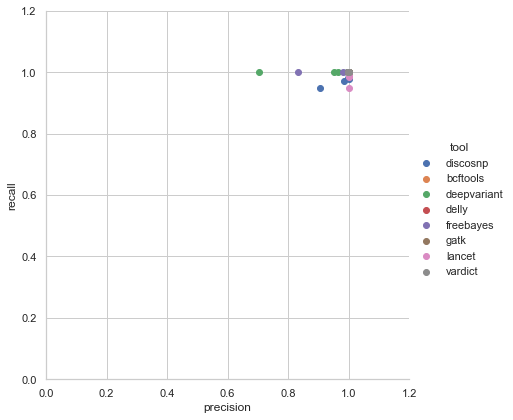

In [108]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_SNPonly, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

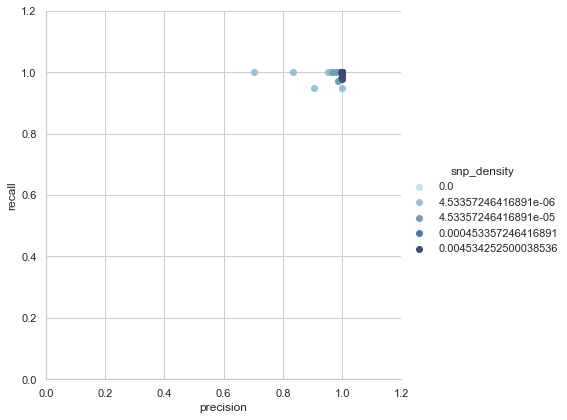

In [109]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_SNPonly, hue='snp_density', palette='ch:r=-.2,d=.3', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

### Indels only

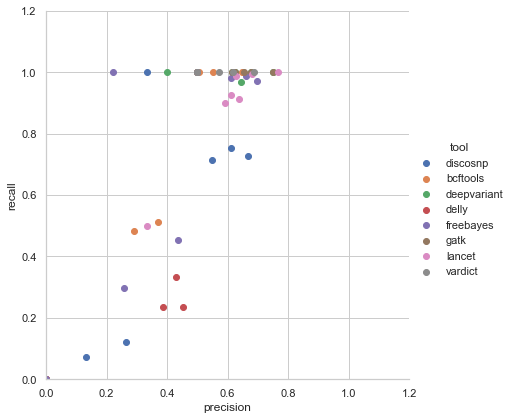

In [110]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_indelonly, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

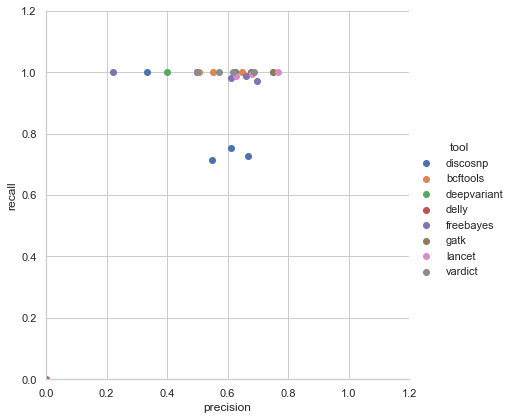

In [111]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=smallindels_df, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

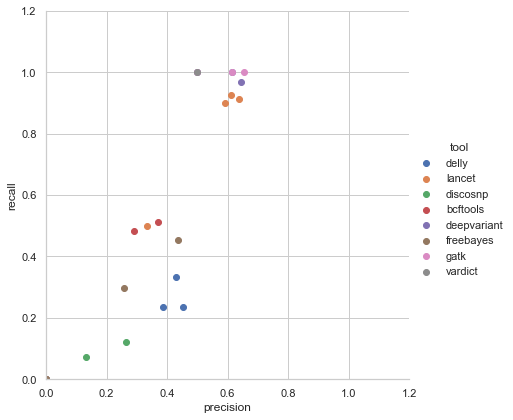

In [112]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=medindels_df, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

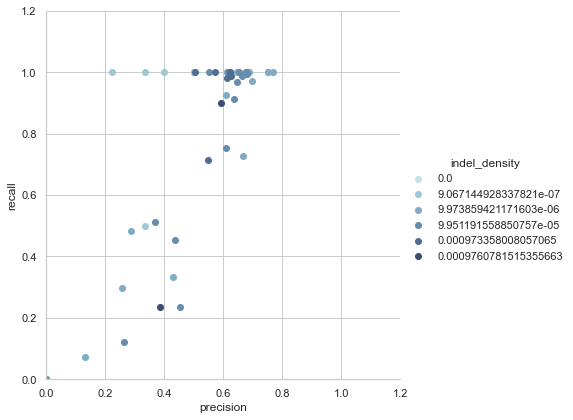

In [113]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_indelonly, hue='indel_density', palette='ch:r=-.2,d=.3', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

### Indels only - NO coverage filter

In [115]:
stats_nocov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/cov_limit_0/20210615_all_indels_cov0.csv', header=None)

In [116]:
stats_nocov.rename(columns={0: 'file_prefix', 1: 'true_pos', 2: 'false_pos', 3: 'false_neg', 4: 'precision', 5: 'recall'}, inplace=True)
stats_nocov.loc[stats_nocov['recall'] == '.' , 'recall'] = np.nan
stats_nocov.loc[stats_nocov['precision'] == '.' , 'precision'] = np.nan
stats_nocov['recall'] = pd.to_numeric(stats_nocov['recall'])
stats_nocov['precision'] = pd.to_numeric(stats_nocov['precision'])

In [117]:
stats_nocov['true_pos'] = pd.to_numeric(stats_nocov['true_pos'])
stats_nocov['false_pos'] = pd.to_numeric(stats_nocov['false_pos'])
stats_nocov['false_neg'] = pd.to_numeric(stats_nocov['false_neg'])

In [118]:
stats_nocov['dataset'] = [name.split('_')[0] for name in stats_nocov['file_prefix']]
stats_nocov['tool'] = [name.split('_')[-2] for name in stats_nocov['file_prefix']]
stats_nocov.loc[stats_nocov['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats_nocov.loc[stats_nocov['tool'] == 'normalized',:]['file_prefix']]
stats_nocov.loc[stats_nocov['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats_nocov.loc[stats_nocov['tool'] == 'normalized',:]['file_prefix']]
stats_nocov['num_snp'] = [int(num_snp[ds]) for ds in stats_nocov['dataset']]
stats_nocov['num_indel'] = [int(num_indel[ds]) for ds in stats_nocov['dataset']]
stats_nocov['total_mutations'] = stats_nocov['num_snp'] + stats_nocov['num_indel']
stats_nocov['low_cov_mutations_filtered'] = stats_nocov['total_mutations'] - stats_nocov['true_pos'] - stats_nocov['false_neg']

In [119]:
stats_nocov['filtered_total_mutations'] = stats_nocov['total_mutations'] - stats_nocov['low_cov_mutations_filtered']
stats_nocov['snp_density'] = stats_nocov['num_snp'] / 4411532
stats_nocov['indel_density'] = stats_nocov['num_indel'] / 4411532
stats_nocov['indel_snp_ratio'] = round(stats_nocov['num_indel']/stats_nocov['num_snp'], 2)

In [120]:
# remove duplicate tools
stats_nocov_noHC = stats_nocov[stats_nocov['tool'] != 'HaplotypeCaller']
stats_nocov_noduptools = stats_nocov_noHC[stats_nocov['tool'] != 'discosnp-edit']

In [121]:
stats_nocov_noduptools

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3indels_discosnp-edit_normalized_...,3444,2,850,0.999420,0.802049,TEST-H37Rv10-3indels,discosnp,0,4294,4294,0,4294,0.0,9.733580e-04,inf
1,TEST-H37Rv10-3indels_mq10_bcftools_normalized,4247,1020,47,0.806341,0.989054,TEST-H37Rv10-3indels,bcftools,0,4294,4294,0,4294,0.0,9.733580e-04,inf
2,TEST-H37Rv10-3indels_mq10_deepvariant_normaliz...,4249,10,45,0.997652,0.989520,TEST-H37Rv10-3indels,deepvariant,0,4294,4294,0,4294,0.0,9.733580e-04,inf
3,TEST-H37Rv10-3indels_mq10_delly_normalized,0,0,4294,NaN,0.000000,TEST-H37Rv10-3indels,delly,0,4294,4294,0,4294,0.0,9.733580e-04,inf
4,TEST-H37Rv10-3indels_mq10_freebayes_normalized,4199,53,95,0.987535,0.977876,TEST-H37Rv10-3indels,freebayes,0,4294,4294,0,4294,0.0,9.733580e-04,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,TEST-H37Rv10-6medindels_mq10_delly_normalized,2,0,2,1.000000,0.500000,TEST-H37Rv10-6medindels,delly,0,4,4,0,4,0.0,9.067145e-07,inf
58,TEST-H37Rv10-6medindels_mq10_freebayes_normalized,2,2,2,0.500000,0.500000,TEST-H37Rv10-6medindels,freebayes,0,4,4,0,4,0.0,9.067145e-07,inf
59,TEST-H37Rv10-6medindels_mq10_gatk_normalized,4,0,0,1.000000,1.000000,TEST-H37Rv10-6medindels,gatk,0,4,4,0,4,0.0,9.067145e-07,inf
60,TEST-H37Rv10-6medindels_mq10_lancet_normalized,3,0,1,1.000000,0.750000,TEST-H37Rv10-6medindels,lancet,0,4,4,0,4,0.0,9.067145e-07,inf


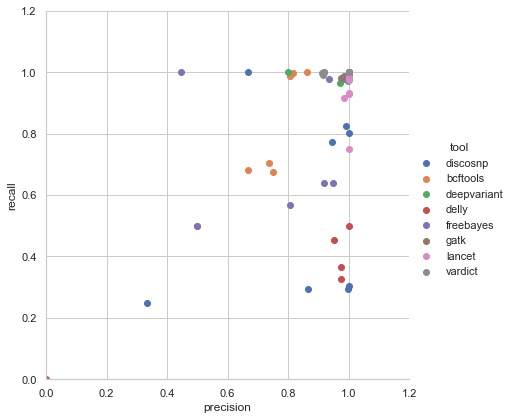

In [122]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_nocov_noduptools, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

In [123]:
smallindels_df_nocov = stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == smallindels[0]]
smallindels_df_nocov = pd.concat([smallindels_df_nocov, stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == smallindels[1]],
                           stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == smallindels[2]], stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == smallindels[3]]])
smallindels_df_nocov

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3indels_discosnp-edit_normalized_...,3444,2,850,0.999420,0.802049,TEST-H37Rv10-3indels,discosnp,0,4294,4294,0,4294,0.0,9.733580e-04,inf
1,TEST-H37Rv10-3indels_mq10_bcftools_normalized,4247,1020,47,0.806341,0.989054,TEST-H37Rv10-3indels,bcftools,0,4294,4294,0,4294,0.0,9.733580e-04,inf
2,TEST-H37Rv10-3indels_mq10_deepvariant_normaliz...,4249,10,45,0.997652,0.989520,TEST-H37Rv10-3indels,deepvariant,0,4294,4294,0,4294,0.0,9.733580e-04,inf
3,TEST-H37Rv10-3indels_mq10_delly_normalized,0,0,4294,NaN,0.000000,TEST-H37Rv10-3indels,delly,0,4294,4294,0,4294,0.0,9.733580e-04,inf
4,TEST-H37Rv10-3indels_mq10_freebayes_normalized,4199,53,95,0.987535,0.977876,TEST-H37Rv10-3indels,freebayes,0,4294,4294,0,4294,0.0,9.733580e-04,inf
5,TEST-H37Rv10-3indels_mq10_gatk_normalized,4254,0,40,1.000000,0.990685,TEST-H37Rv10-3indels,gatk,0,4294,4294,0,4294,0.0,9.733580e-04,inf
6,TEST-H37Rv10-3indels_mq10_lancet_normalized,4188,0,106,1.000000,0.975314,TEST-H37Rv10-3indels,lancet,0,4294,4294,0,4294,0.0,9.733580e-04,inf
7,TEST-H37Rv10-3indels_mq10_vardict_normalized,4254,389,40,0.916218,0.990685,TEST-H37Rv10-3indels,vardict,0,4294,4294,0,4294,0.0,9.733580e-04,inf
15,TEST-H37Rv10-4indels_discosnp-edit_normalized_...,362,3,77,0.991781,0.824601,TEST-H37Rv10-4indels,discosnp,0,439,439,0,439,0.0,9.951192e-05,inf
16,TEST-H37Rv10-4indels_mq10_bcftools_normalized,438,98,1,0.817164,0.997722,TEST-H37Rv10-4indels,bcftools,0,439,439,0,439,0.0,9.951192e-05,inf


In [124]:
medindels_df_nocov = stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == medindels[0]]
medindels_df_nocov = pd.concat([medindels_df_nocov, stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == medindels[1]],
                           stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == medindels[2]], stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == medindels[3]]])
medindels_df_nocov

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
8,TEST-H37Rv10-3medindels_discosnp-edit_normaliz...,1269,3,3037,0.997642,0.294705,TEST-H37Rv10-3medindels,discosnp,0,4306,4306,0,4306,0.0,9.760782e-04,inf
9,TEST-H37Rv10-3medindels_mq10_bcftools_normalized,3029,1082,1277,0.736804,0.703437,TEST-H37Rv10-3medindels,bcftools,0,4306,4306,0,4306,0.0,9.760782e-04,inf
10,TEST-H37Rv10-3medindels_mq10_deepvariant_norma...,4159,120,147,0.971956,0.965862,TEST-H37Rv10-3medindels,deepvariant,0,4306,4306,0,4306,0.0,9.760782e-04,inf
11,TEST-H37Rv10-3medindels_mq10_delly_normalized,1571,39,2735,0.975776,0.364840,TEST-H37Rv10-3medindels,delly,0,4306,4306,0,4306,0.0,9.760782e-04,inf
12,TEST-H37Rv10-3medindels_mq10_freebayes_normalized,2750,250,1556,0.916667,0.638644,TEST-H37Rv10-3medindels,freebayes,0,4306,4306,0,4306,0.0,9.760782e-04,inf
13,TEST-H37Rv10-3medindels_mq10_gatk_normalized,4228,113,78,0.973969,0.981886,TEST-H37Rv10-3medindels,gatk,0,4306,4306,0,4306,0.0,9.760782e-04,inf
14,TEST-H37Rv10-3medindels_mq10_lancet_normalized,3945,59,361,0.985265,0.916163,TEST-H37Rv10-3medindels,lancet,0,4306,4306,0,4306,0.0,9.760782e-04,inf
23,TEST-H37Rv10-4medindels_discosnp-edit_normaliz...,133,0,306,1.000000,0.302961,TEST-H37Rv10-4medindels,discosnp,0,439,439,0,439,0.0,9.951192e-05,inf
24,TEST-H37Rv10-4medindels_mq10_bcftools_normalized,297,99,142,0.750000,0.676538,TEST-H37Rv10-4medindels,bcftools,0,439,439,0,439,0.0,9.951192e-05,inf
25,TEST-H37Rv10-4medindels_mq10_deepvariant_norma...,427,1,12,0.997664,0.972665,TEST-H37Rv10-4medindels,deepvariant,0,439,439,0,439,0.0,9.951192e-05,inf


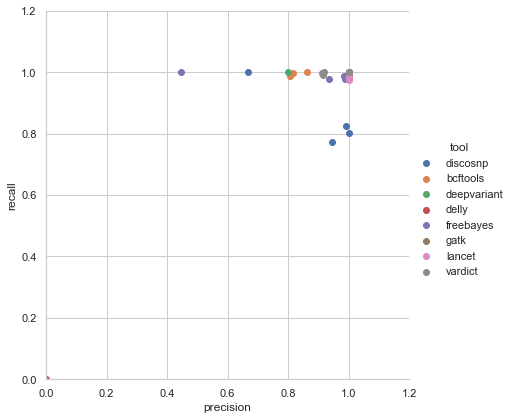

In [125]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=smallindels_df_nocov, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

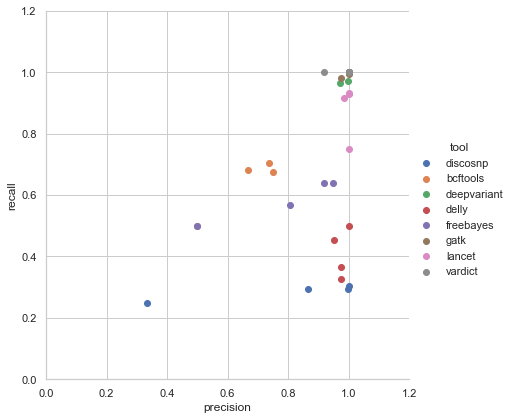

In [126]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=medindels_df_nocov, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

### All variants

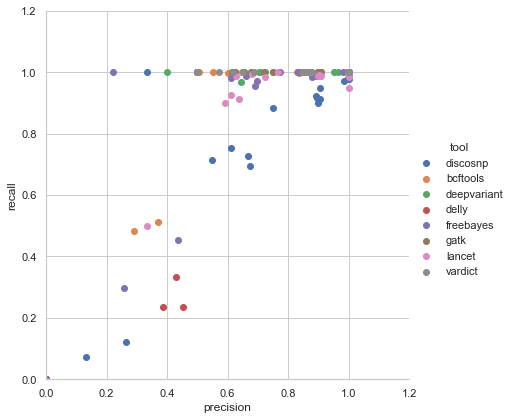

In [114]:
# https://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_noduptools, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

#### WIP

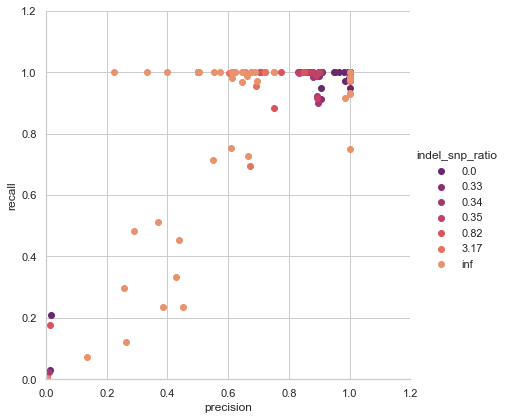

In [50]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_noHC, hue='indel_snp_ratio', palette='flare_r', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

In [69]:
snps_vs_indels = pd.concat([stats_SNPonly, stats_indelonly])

In [70]:
snps_vs_indels['type'] = ''
snps_vs_indels.loc[snps_vs_indels['num_indel'] == 0, 'type'] = 'SNP'
snps_vs_indels.loc[snps_vs_indels['num_indel'] > 0, 'type'] = 'indel'

In [71]:
snps_vs_indels['mutation_density'] = np.nan
snps_vs_indels.loc[snps_vs_indels['type'] == 'SNP', 'mutation_density'] = [dens for dens in snps_vs_indels.loc[snps_vs_indels['type'] == 'SNP',:]['snp_density']]
snps_vs_indels.loc[snps_vs_indels['type'] == 'indel', 'mutation_density'] = [denct for denct in snps_vs_indels.loc[snps_vs_indels['type'] == 'indel', :]['indel_density']]

In [72]:
snps_vs_indels

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_snp_ratio,indel_density,type,mutation_density
56,TEST-H37Rv20003snps_discosnp-edit_normalized_P...,19354,12,432,0.999380,0.978166,TEST-H37Rv20003snps,discosnp,20003,0,20003,217,19786,0.004534,0.0,0.0,SNP,0.004534
58,TEST-H37Rv20003snps_mq10_bcftools_normalized,19786,23,0,0.998839,1.000000,TEST-H37Rv20003snps,bcftools,20003,0,20003,217,19786,0.004534,0.0,0.0,SNP,0.004534
59,TEST-H37Rv20003snps_mq10_deepvariant_normalize...,19786,21,0,0.998940,1.000000,TEST-H37Rv20003snps,deepvariant,20003,0,20003,217,19786,0.004534,0.0,0.0,SNP,0.004534
60,TEST-H37Rv20003snps_mq10_deepvariant_normalized,19758,54,0,0.997274,1.000000,TEST-H37Rv20003snps,deepvariant,20003,0,20003,245,19758,0.004534,0.0,0.0,SNP,0.004534
61,TEST-H37Rv20003snps_mq10_delly_normalized,0,0,19786,NaN,0.000000,TEST-H37Rv20003snps,delly,20003,0,20003,217,19786,0.004534,0.0,0.0,SNP,0.004534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,TEST-MTBREF_mq10_delly_normalized,0,0,0,NaN,NaN,TEST-MTBREF,delly,0,0,0,0,0,0.000000,NaN,0.0,SNP,0.000000
107,TEST-MTBREF_mq10_freebayes_normalized,0,5,0,0.000000,NaN,TEST-MTBREF,freebayes,0,0,0,0,0,0.000000,NaN,0.0,SNP,0.000000
109,TEST-MTBREF_mq10_gatk_normalized,0,0,0,NaN,NaN,TEST-MTBREF,gatk,0,0,0,0,0,0.000000,NaN,0.0,SNP,0.000000
110,TEST-MTBREF_mq10_lancet_normalized,0,0,0,NaN,NaN,TEST-MTBREF,lancet,0,0,0,0,0,0.000000,NaN,0.0,SNP,0.000000


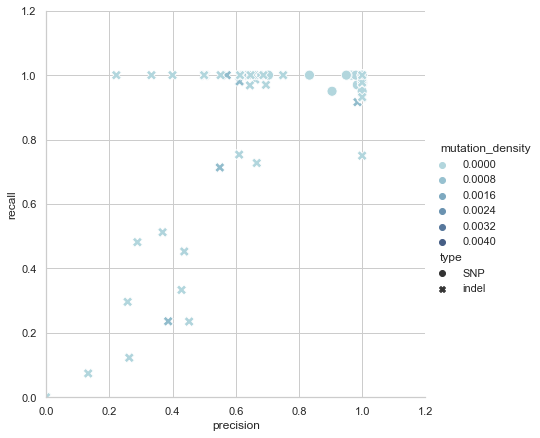

In [73]:
fg = seaborn.relplot(data=snps_vs_indels, x='precision', y='recall', hue='mutation_density', palette='ch:r=-.2,d=.3,l=.8', style='type', height=6, aspect=1, s=100)
fg.set(xlim=(0, 1.2), ylim=(0, 1.2))